In [1]:
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
from load_dataset import load_data

1 Physical GPUs, 1 Logical GPUs


In [3]:
# No info messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [4]:
# Limit GPU memory growth for RTX cards
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Enable FP16 on RTX cards for faster processing
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs


In [5]:
from tensorflow.keras import datasets, layers, models

Our dataset directory should contain 2 folders inside of it: *bad* and *healthy*. Those 2 are going to be our final classes, stored under `CLASS_NAMES`.

In [6]:
data_dir = os.path.join("dataset")
data_dir = pathlib.Path(data_dir)

list_ds = tf.data.Dataset.list_files(str(data_dir / "*/*"))

image_count = len(list(data_dir.glob("*/*.jpg")))

CLASS_NAMES = np.array([item.name for item in data_dir.glob("*")])
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [7]:
ds = load_data()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4


Splits our dataset into training data and testing data with a ratio of 80/20 set through `test_size`. Also fixed our random seed through `random_state` in order to provide reproducibility in later runs.

In [8]:
from sklearn.model_selection import train_test_split
ds_train, ds_test = train_test_split(np.array(list(ds.as_numpy_iterator())) ,test_size=0.2, random_state=42)

Splits our labels and data into 2 different arrays

In [9]:
train_data = ds_train[:,0]
train_label = ds_train[:,1]
test_data = ds_test[:,0]
test_label = ds_test[:,1]

In [ ]:
Lots of reshapes into our arrays

In [10]:
for i in range(len(train_data)):
    train_data[i] = train_data[i].reshape(-1, 256, 256, 3).astype(np.float16) 
for i in range(len(test_data)):
    test_data[i] = test_data[i].reshape(-1, 256, 256, 3).astype(np.float16) 

In [11]:
train_data = np.vstack(train_data)
test_data = np.vstack(test_data)

In [12]:
for i in range(len(train_label)):
    train_label[i] = int(train_label[i][1])
for i in range(len(test_label)):
    test_label[i] = int(test_label[i][1])

Let's see if everything worked out as we wanted by plotting some of our data

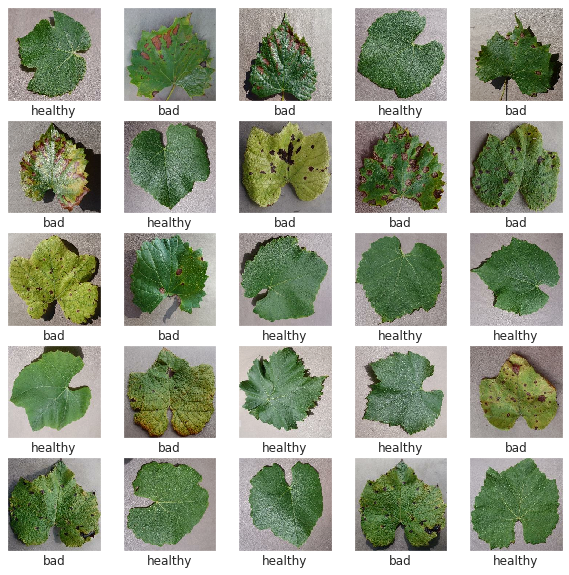

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i].astype(np.float32), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(CLASS_NAMES[train_label[i]])
plt.show()

In [14]:
train_label = tf.convert_to_tensor(train_label, dtype=tf.int8)
test_label = tf.convert_to_tensor(test_label, dtype=tf.int8)

This model is based on AlexNet, which can be seen [here](https://miro.medium.com/max/1400/1*5bnqbGcBSLzaNMsz5dHkfg.png). Some layers are merged into a single one since we're training with a single GPU with enough RAM.

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(96, (11, 11), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Conv2D(256, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5, seed=42))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1, activation='tanh'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 246, 246, 96)      34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 256)         8

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

import time
start = time.time()

history = model.fit(train_data, train_label, epochs=100, batch_size=128,
                    validation_data=(test_data, test_label))
end = time.time() - start

print("Took ", end, "s")

Train on 5618 samples, validate on 1405 samples
Epoch 1/100
5618/5618 [==============================] - 42s 7ms/sample - loss: 1.3552 - accuracy: 0.5077 - val_loss: 0.6904 - val_accuracy: 0.5253
Epoch 2/100
5618/5618 [==============================] - 33s 6ms/sample - loss: 0.6596 - accuracy: 0.5951 - val_loss: 0.5882 - val_accuracy: 0.7374
Epoch 3/100
5618/5618 [==============================] - 33s 6ms/sample - loss: 0.4034 - accuracy: 0.8745 - val_loss: 0.2262 - val_accuracy: 0.9053
Epoch 4/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 0.2064 - accuracy: 0.9199 - val_loss: 0.1654 - val_accuracy: 0.9167
Epoch 5/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 0.1584 - accuracy: 0.9379 - val_loss: 0.1550 - val_accuracy: 0.9559
Epoch 6/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 0.1303 - accuracy: 0.9494 - val_loss: 0.2987 - val_accuracy: 0.9580
Epoch 7/100
5618/5618 [==============================] - 34s 6ms

Epoch 56/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 1.3772 - accuracy: 0.6228 - val_loss: 1.4088 - val_accuracy: 0.6456
Epoch 57/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 1.3799 - accuracy: 0.6205 - val_loss: 1.4088 - val_accuracy: 0.6456
Epoch 58/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 1.3744 - accuracy: 0.6246 - val_loss: 1.4088 - val_accuracy: 0.6456
Epoch 59/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 1.3776 - accuracy: 0.6218 - val_loss: 1.4088 - val_accuracy: 0.6456
Epoch 60/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 1.3840 - accuracy: 0.6207 - val_loss: 1.4088 - val_accuracy: 0.6456
Epoch 61/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 1.3821 - accuracy: 0.6214 - val_loss: 1.4088 - val_accuracy: 0.6456
Epoch 62/100
5618/5618 [==============================] - 34s 6ms/sample - loss: 1.3782 - accuracy: 0.6210

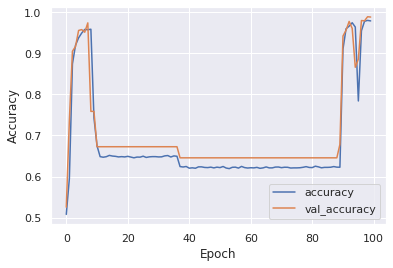

1405/1405 - 4s - loss: 0.0555 - accuracy: 0.9886
0.9886121


In [18]:
plt.close()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_data,  test_label, verbose=2)
print(test_acc)

In [20]:
model.save('model_alex.h5')